In [1]:
import time
import requests
from bs4 import BeautifulSoup
import pymongo
import pandas as pd
import numpy as np

import sys
import os
import csv
import shutil
from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

source_path = 'test_data'
#source_file = 'test_strains_reviews.csv'
target_path = '/Users/jordanweil/green_rex/test_data'

In [2]:
reviews = pd.read_csv('test_data/test_strains_reviews.csv')
r = reviews.set_index('Unnamed: 0')

In [3]:
def get_reviews2(l):
    """Pass in a list of URL's and return them in a mongo db table as a dicitonary with 
    {'url', 'html'} and their corresponding values"""
    r = requests.get(l)
    html = (r.content)
    return html

In [4]:
# def get_stars_list(d):
#     stars = []
#     for key, values in d.items():
#         soup = BeautifulSoup(values, 'html.parser')
#         tags = soup.select("div.div.stars")
#         for t in tags:
#             stars.append(t.attrs['style'])
#     return stars

In [5]:
def star_int_conv(s):
    star = (int((s[6:].split(';')[0]).strip('px'))/22)
    
    return star

In [6]:
def list_o_strains(i):
    LOS = []
    Type = []
    r = requests.get(i)
    soup2 = BeautifulSoup(r.content, 'html.parser')
    strains = soup2.find_all('a', class_="ga_Explore_Strain_Tile")
    for s in strains:
        LOS.append(str(s.attrs['href'])[8:])
        Type.append(str(s.attrs['href'])[1:7])
    z = list(zip(LOS,Type))
    return z

In [7]:
def strain_dict_entry(strain, stype, user_id, userstars, userreview, straindict):
    if straindict is None:
        straindict = {}
        
    if strain not in straindict:
        straindict[strain] = {
            "stype" : stype,
            "user_rev" : [] 
        }
        
    straindict[strain]['user_rev'].append({'user':user_id,
                                         'stars':userstars,
                                         'review':userreview
                                        })
    return straindict

In [8]:
def parse_docs2(d):
    """Parse the HTML docs that we have stored in a dictionary, return as a list.
    Also scrape and parse star rating for each review """
    strain_text= []
    star_rate = []
    user_name = []
    
    soup = BeautifulSoup(d, 'html.parser')
    revs = soup.find_all('p',class_='strain-review__text') 
    for r in revs:
        strain_text.append(r.text)
        
    tags = soup.select("div.div.stars")
    for t in tags:
        star = t.attrs['style']
        star_rate.append(star_int_conv(star))
    
    users = soup.find_all('div', class_='strain-review__title')
    for u in users:
        temp = u.find('h2')
        user_name.append(temp.text)
        
    return star_rate, strain_text, user_name

In [13]:
def scraper_dummy1(los):
    """pass in a list of strains to be scraped from Leafly.
    returns dictionary keyed by strains w/strain info(reviews) as values"""
    cnt = 0
    strain_dict = None
    for s in los:
        strain = s[0]
        stype = s[1]
        url = "https://www.leafly.com/{}/{}/reviews?page=".format(stype, strain)
    
        for i in range(1,100):
            rev_url=url+str(i)
            d = get_reviews2(rev_url)
            star, reviews, users = parse_docs2(d)
            #print(star)
            if len(star) == 0:
                break

            for userstars, userreview ,user_id in zip(star, reviews, users):
                strain_dict = strain_dict_entry(strain, stype, user_id, userstars, userreview, strain_dict)
                
            
            if cnt % 10 == 0:
                print(cnt)
            cnt +=1
            
    return strain_dict         

In [14]:
test_strains = list_o_strains('https://www.leafly.com/explore')

In [15]:
test = test_strains[:4]
test

[('blue-dream', 'hybrid'),
 ('sour-diesel', 'sativa'),
 ('gsc', 'hybrid'),
 ('green-crack', 'sativa')]

In [16]:
d = scraper_dummy1(test)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180


In [17]:
for k in d.keys():
    print(k,len(d[k]['user_rev']))

blue-dream 436
sour-diesel 502
gsc 280
green-crack 243


In [18]:
d['gsc']['user_rev'][3]

{'user': 'BenchAdventures',
 'stars': 5.0,
 'review': '"This is what I\'ve been smoking recently when I don\'t need to "do" anything. If you\'re like me, you\'ll want to make sure the floor is clear of tripping hazards, your laptop is away from your water, etc.\nSet out some snacks before you start smoking, and make sure you\'re in a safe environment.\nHybrids generally put me in the couch more than Indica, but GSC makes fine motor skills especially hard. It\'s also especially de..."'}

In [46]:
def create_files(d):
    cnt = 0
    for strain in d.keys():

        if not os.path.isdir(os.path.join(target_path, strain)):
             os.mkdir(os.path.join(target_path, strain))

        for rev in d[strain]['user_rev']:

            with open(os.path.join(target_path, strain, strain+'{:05d}.txt'.format(cnt)), mode='w') as strain_file:
                strain_file.write(rev['review'])

            cnt += 1

In [47]:
create_files(d)

In [28]:
stopwords_ = "a,able,about,across,after,all,almost,also,am,among,an,and,any,\
are,as,at,be,because,been,but,by,can,could,dear,did,do,does,either,\
else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,\
how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,\
me,might,most,must,my,neither,no,of,off,often,on,only,or,other,our,\
own,rather,said,say,says,she,should,since,so,some,than,that,the,their,\
them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,\
what,when,where,which,while,who,whom,why,will,with,would,yet,you,your]".split(',')

In [44]:
    dataset = load_files(target_path, shuffle=False)
    print('n_samples {}'.format(len(dataset.data)))

    # split the dataset in training and test set:
    docs_train, docs_test, y_train, y_test = train_test_split(
        dataset.data, dataset.target, test_size=0.25, random_state=None)

    # TASK: Build a vectorizer / classifier pipeline that filters out tokens
    # that are too rare or too frequent
    clf = Pipeline([
        ('vect',TfidfVectorizer(analyzer='character', stop_words=stopwords_)),
        ('clf', Perceptron())
    ])

    # TfidfVectorizer().get_params()
    # TASK: Build a grid search to find out whether unigrams or bigrams are
    # more useful.
    # Fit the pipeline on the training set using grid search for the parameters
    parameters = {
        'vect__ngram_range': [(1, 1), (1, 5), (1,10),(1,20)],
        'vect__analyzer': ['word']#,'char']
    }
    gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
    cclf = gs_clf.fit(docs_train, y_train)

n_samples 1463


/Users/jordanweil/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/jordanweil/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Users/jordanweil/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['your'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/Users/jordanweil/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol p

{'vect__analyzer': 'word', 'vect__ngram_range': (1, 5)}
0.4808743169398907
                    precision    recall  f1-score   support

.ipynb_checkpoints       0.00      0.00      0.00         1
        blue-dream       0.45      0.64      0.53       111
       green-crack       0.38      0.17      0.24        52
               gsc       0.58      0.35      0.43        75
       sour-diesel       0.56      0.55      0.55       127

         micro avg       0.48      0.48      0.48       366
         macro avg       0.39      0.34      0.35       366
      weighted avg       0.50      0.48      0.47       366

[[ 0  1  0  0  0]
 [ 4 71  5  7 24]
 [ 4 17  9  4 18]
 [ 2 30  3 26 14]
 [ 3 39  7  8 70]]


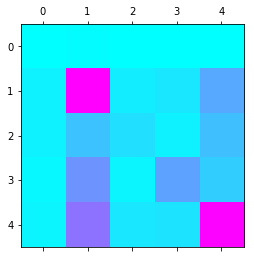

In [45]:
# TASK: Predict the outcome on the testing set in a variable named y_predicted
y_predicted = gs_clf.predict(docs_test)

print(gs_clf.best_params_)
print(cclf.score(docs_test, y_test))

# Print the classification report
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

# Plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

plt.matshow(cm, cmap=plt.cm.cool)
plt.show()

In [46]:
test_strings = [
    u'trippy  fun, hyphy',
    u'high, smile, amazing',
    u'happy, hike, awake',
    u'giggly, happy, fun'
]

predicted = cclf.predict(test_strings)

for s, p in zip(test_strings, predicted):
    print(u'The class of {} is {}'.format(s, dataset.target_names[p]))


The class of trippy  fun, hyphy is blue-dream
The class of high, smile, amazing is blue-dream
The class of happy, hike, awake is green-crack
The class of giggly, happy, fun is .ipynb_checkpoints
